In [162]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy.stats import norm

### Likelihood function

\begin{align*}
\mathcal{L}(r) = \frac{1}{\sqrt{2\pi}\sigma_\varpi}\exp{\left[-\frac{1}{\sqrt{2\pi}\sigma^2_\varpi}\left(\varpi-\frac{1}{r}\right)^2\right]}
\end{align*}

In [ ]:
def likelihood_func(r, parallax, parallax_error):
  return norm.pdf(x=1/r, scale=parallax_error, loc=parallax)

### Uniform Prior

all these are improper => do not integrate to 1

\begin{align*}
P^*_u(r; r_{\text{max}}) = \begin{cases}
                            1 &  0 \le r \le r_{\text{max}} \\
                            0 & \text{otherwise}
                          \end{cases}
\end{align*}

### Constant Volume Density Prior

\begin{align*}
P^*_c(r; r_{\text{lim}}) = \begin{cases}
                            r^2 &  0 \le r \le r_{\text{lim}} \\
                            0 & \text{otherwise}
                          \end{cases}
\end{align*}

### Exponentially Decreasing Volumne Density Prior

\begin{align*}
P^*_e(r; L) = \begin{cases}
                            r^2e^{-r/L} &  r > 0 \\
                            0 & \text{otherwise}
                          \end{cases}
\end{align*}

In [99]:
class Prior:
  def uniform(self, r, rmax = 1e4):
    condlist = [r < 0, rmax < r]
    choicelist = [0, 0]
    return np.select(condlist, choicelist, default=1)

  def constant_density(self, r, rlim = 1e4):
    condlist = [r < 0, rlim < r]
    choicelist = [0, 0]
    return np.select(condlist, choicelist, default=r*r)
    
  def exponentially_decreasing(self, r, L = 1e4):
    condlist = [r <= 0, 0 < r]
    choicelist = [0, r*r*np.exp(-r/L)]
    return np.select(condlist, choicelist)
  

In [100]:
class Posterior:
  def __init__(self, parallax, parallax_error):
    self.parallax = parallax
    self.parallax_error = parallax_error
    self.prior = Prior()

  def uniform(self, r, rmax = 1e4):
    likelihood = likelihood_func(r, self.parallax, self.parallax_error)
    posterior = likelihood * self.prior.uniform(r, rmax)
    return posterior

  def constant_density(self, r, rlim = 1e4):
    likelihood = likelihood_func(r, self.parallax, self.parallax_error)
    posterior = likelihood * self.prior.constant_density(r, rlim)
    return posterior
    
  def exponentially_decreasing(self, r, L = 1e4):
    likelihood = likelihood_func(r, self.parallax, self.parallax_error)
    posterior = likelihood * self.prior.exponentially_decreasing(r, L)
    return posterior

In [ ]:
# @lru_cache(maxsize=None)
# def uniform_normalization_func(parallax, parallax_error, rmax):
#     r = np.linspace(0, rmax, int(1e5))
#     likelihood = likelihood_func(r, parallax, parallax_error)
#     posterior_improper = likelihood * uniform_prior(r, rmax)
#     area = integrate.simpson(y=posterior_improper, x=r)
#     return area

# def uniform_posterior(r, parallax, parallax_error, rmax = 1e4):
#   likelihood = likelihood_func(r, parallax, parallax_error)
#   posterior_improper = likelihood*uniform_prior(r, rmax)
#   normalization = uniform_normalization_func(parallax, parallax_error, rmax)
#   return posterior_improper/normalization

# @lru_cache(maxsize=None)
# def constant_normalization_func(parallax, parallax_error, rlim):
#     r = np.linspace(0, rlim, int(1e5))
#     likelihood = likelihood_func(r, parallax, parallax_error)
#     posterior_improper = likelihood * constant_density_prior(r, rlim)
#     area = integrate.simpson(y=posterior_improper, x=r)
#     return area

# def constant_density_posterior(r, parallax, parallax_error, rlim = 1e4):
#   likelihood = likelihood_func(r, parallax, parallax_error)
#   posterior_improper = likelihood*constant_density_prior(r, rlim)
#   normalization = constant_normalization_func(parallax, parallax_error, rlim)
#   return posterior_improper/normalization

# @lru_cache(maxsize=None)
# def exponentially_normalization_func(parallax, parallax_error, L):
#     r = np.linspace(0, L*10, int(1e5))
#     likelihood = likelihood_func(r, parallax, parallax_error)
#     posterior_improper = likelihood * exponentially_decreasing_prior(r, L)
#     area = integrate.simpson(y=posterior_improper, x=r)
#     return area

# def exponentially_posterior(r, parallax, parallax_error, L = 1e4):
#   likelihood = likelihood_func(r, parallax, parallax_error)
#   posterior_improper = likelihood*exponentially_decreasing_prior(r, L)
#   normalization = exponentially_normalization_func(parallax, parallax_error, L, )
#   return posterior_improper/normalization

# Fetch data from Gaia

In [64]:
from astroquery.gaia import Gaia

In [65]:
# Grab data from Gaia DR2
job = Gaia.launch_job_async(""" 
SELECT TOP 2000 *
FROM gaiadr2.gaia_source
WHERE parallax > 0 AND (random_index BETWEEN 12345 AND 56789)
""")
res = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [66]:
# See the columns
res.colnames

['solution_id',
 'DESIGNATION',
 'SOURCE_ID',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

In [67]:
# Check what's in it
res[["SOURCE_ID", "parallax", "parallax_error"]]

SOURCE_ID,parallax,parallax_error
,mas,mas
int64,float64,float64
2027838817078343808,0.43243125624106177,0.12165888759411657
4161933574533589888,3.264891413120491,3.362813363303925
4072990574296090368,0.26449423937762556,0.15245530336289018
2032725596523174144,0.26907084701226136,0.0902095990171838
4105959219961581440,0.29983693271213413,0.0729436495693375
5932609296381196032,4.649485451899394,1.5348297532832427
5720850778475448576,5.53139684876496,2.306038067982972
5621586250253312512,0.3304770627176499,0.08232640302471737


In [68]:
# Add new column, relative error
res["f"]= res["parallax_error"]/res["parallax"]
res[["SOURCE_ID", "parallax", "parallax_error", "f"]]

SOURCE_ID,parallax,parallax_error,f
,mas,mas,
int64,float64,float64,float64
2027838817078343808,0.43243125624106177,0.12165888759411657,0.2813369427817146
4161933574533589888,3.264891413120491,3.362813363303925,1.0299924064212118
4072990574296090368,0.26449423937762556,0.15245530336289018,0.5764031145692577
2032725596523174144,0.26907084701226136,0.0902095990171838,0.3352633702939695
4105959219961581440,0.29983693271213413,0.0729436495693375,0.24327773403208086
5932609296381196032,4.649485451899394,1.5348297532832427,0.3301074428905329
5720850778475448576,5.53139684876496,2.306038067982972,0.41689976890699143
5621586250253312512,0.3304770627176499,0.08232640302471737,0.24911381851349446


In [69]:
# Sort by relative error
res.sort("f")
res[["SOURCE_ID", "parallax", "parallax_error", "f"]]

SOURCE_ID,parallax,parallax_error,f
,mas,mas,
int64,float64,float64,float64
215287851349184512,2.800231251651043,0.022593363015767472,0.008068391852439405
5563497882720528768,2.400647754778993,0.023603974523109514,0.009832335658624158
5571494218471085184,2.2564500640313887,0.023786713091161954,0.010541652780325417
3026973485713987584,2.561201909336577,0.027190187500150443,0.010616182738671103
3587187751119645440,4.153332859383128,0.04552114664433956,0.010960148917874252
5123452850878106752,2.289140480844756,0.030048862212181362,0.013126700813526525
5373961525708351104,1.3157375846059942,0.017609080969650255,0.013383429321830466
1924354191396309504,1.3233438932901307,0.01818030236562608,0.013738154124417166


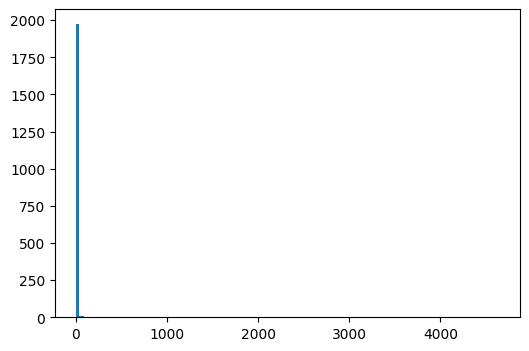

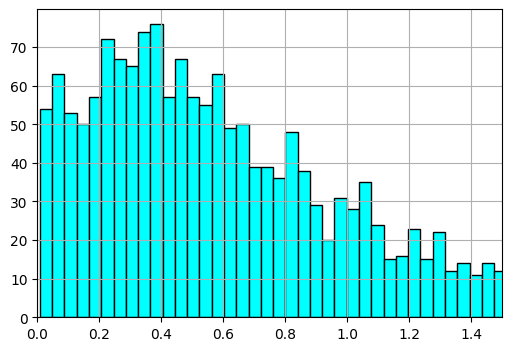

In [70]:
# Sneak peek relative error distribution
plt.figure(figsize=(6,4))
plt.hist(res["f"], bins=150)
plt.show()

# See only f < 2
plt.figure(figsize=(6,4))
plt.hist(res["f"][res["f"]<2], bins=50, edgecolor="k", color="aqua")
plt.xlim(0,1.5)
plt.grid()
plt.show()

In [143]:
# Init Data, just change the index as you like
index = int(input()) 
# index = 50
parallax = res["parallax"][index]/1000
parallax_error = res["parallax_error"][index]/1000
f = res["f"][index]
source_id = res["SOURCE_ID"][index]

## Print the data that being used
print("source_id: ", source_id)
print("parallax (mas) = ", parallax*1000)
print("parallax_error (mas) = ", parallax_error*1000)
print("f = ", f)

source_id:  1197329988979610368
parallax (mas) =  2.805764571499006
parallax_error (mas) =  0.43318387250477125
f =  0.15439067015994815


In [144]:

# Preliminary 
## Trust me, rmax = 15_000 pc is reasonable
rmax = 1.5e4
r = np.linspace(0.0001, rmax, int(1e5))
## Likelihood function, see Bailer-Jones
likelihood = likelihood_func(r, parallax, parallax_error)
prior = Prior()
posterior = Posterior(parallax, parallax_error)

# Prior 1, Uniform
prior_uniform = prior.uniform(r, rmax)
posterior_uniform = posterior.uniform(r, rmax)

# Prior 2, Constant Volume Density
prior_constant = prior.constant_density(r, rlim=rmax)
posterior_constant = posterior.constant_density(r, rlim=rmax)

# Prior 3, Exponentially Decreasing
## scale length 1_000, seems reasonable
L = 1e3
prior_exponential = prior.exponentially_decreasing(r, L)
posterior_exponential = posterior.exponentially_decreasing(r, L)

Text(0.5, 1.0, 'Likelihood function')

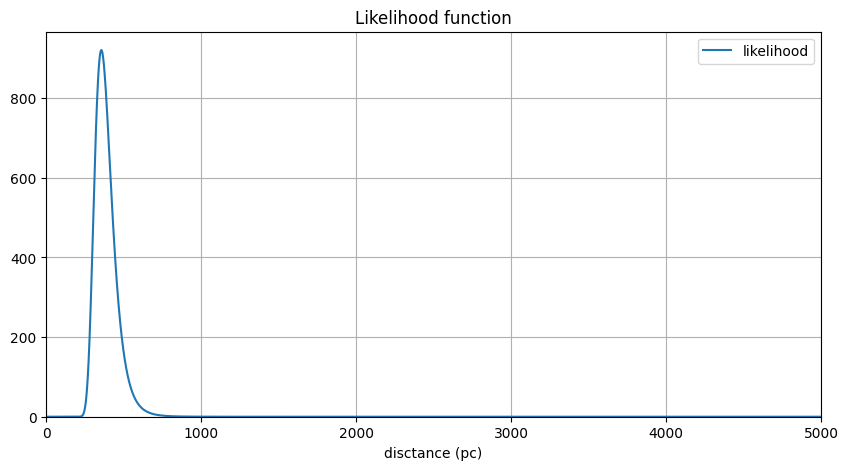

In [145]:
fig, ax = plt.subplots(figsize=(10,5))

xmax = 5000
xmin = 0

ax.plot(r, likelihood, label="likelihood")
ax.legend(loc="best")
ax.grid()
ax.set_xlim(xmin, xmax)
ax.set_ylim(0)
ax.set_xlabel("disctance (pc)")
ax.set_title(f"Likelihood function")

source_id:  1197329988979610368
parallax (mas) =  2.805764571499006
parallax_error (mas) =  0.43318387250477125
f =  0.15439067015994815


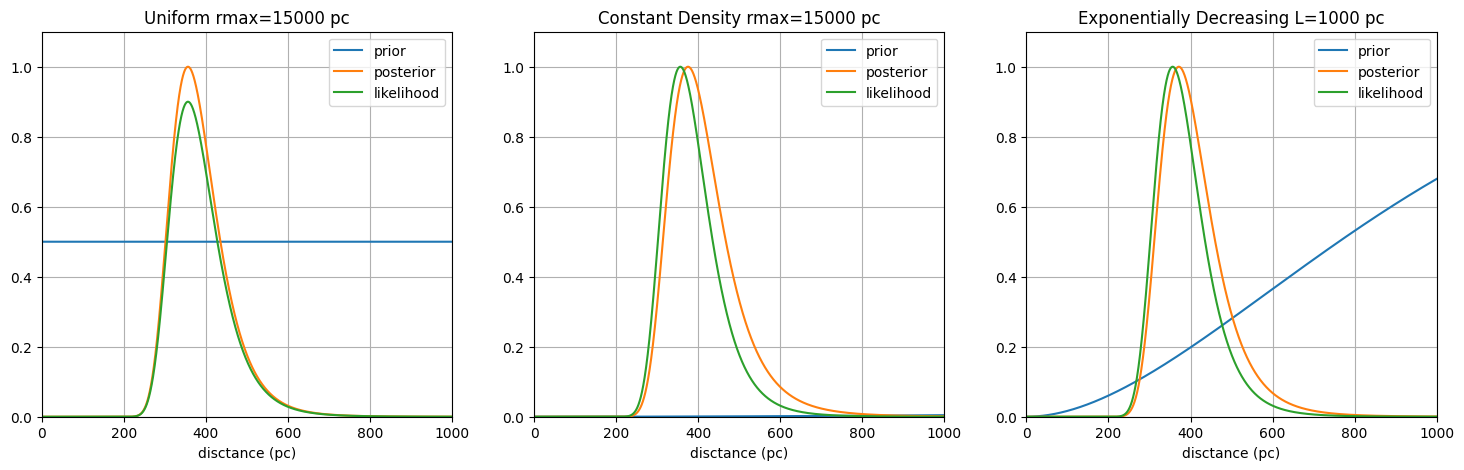

In [148]:
## Print the data that being used
print("source_id: ", source_id)
print("parallax (mas) = ", parallax*1000)
print("parallax_error (mas) = ", parallax_error*1000)
print("f = ", parallax_error/parallax)
xmax = 1000
xmin = 0
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
maxval_like= np.max(likelihood)

maxval_post = np.max(posterior_uniform)
ax1.plot(r, prior_uniform/2, label="prior") # divide by 2 just to scale it up, the absolute value doesn't really matter
ax1.plot(r, posterior_uniform/maxval_post, label="posterior") # divide by maxval to scale it down
ax1.plot(r, likelihood/maxval_like*.9, label="likelihood") # same, but scale 90%
ax1.legend(loc="best")
ax1.grid()
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(0, 1.1)
ax1.set_xlabel("disctance (pc)")
ax1.set_title(f"Uniform rmax={int(rmax)} pc")

maxval_post = np.max(posterior_constant)
maxval_pri = np.max(prior_constant)
ax2.plot(r, prior_constant/maxval_pri, label="prior")
ax2.plot(r, posterior_constant/maxval_post, label="posterior")
ax2.plot(r, likelihood/maxval_like, label="likelihood") # same
ax2.legend(loc="best")
ax2.grid()
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(0, 1.1)
ax2.set_xlabel("disctance (pc)")
ax2.set_title(f"Constant Density rmax={int(rmax)} pc")

maxval_post = np.max(posterior_exponential)
maxval_pri = np.max(prior_exponential)
ax3.plot(r, prior_exponential/maxval_pri, label="prior")
ax3.plot(r, posterior_exponential/maxval_post, label="posterior")
ax3.plot(r, likelihood/maxval_like, label="likelihood") # same
ax3.legend(loc="best")
ax3.grid()
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(0, 1.1)
ax3.set_xlabel("disctance (pc)")
ax3.set_title(f"Exponentially Decreasing L={int(L)} pc")

plt.show()

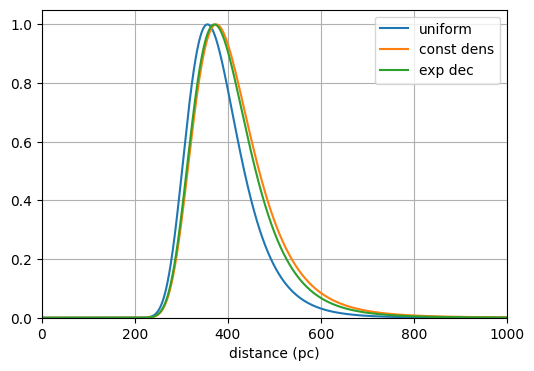

In [150]:
# Create interpolation function for posterior, just in case
# from scipy import interpolate
# p1 = interpolate.interp1d(r, posterior_uniform, kind="cubic")
# p2 = interpolate.interp1d(r, posterior_, kind="cubic")
# p3 = interpolate.interp1d(r, posterior3, kind="cubic")

# Plot all posteriors in one figure
plt.figure(figsize=(6,4))
maxval = np.max(posterior_uniform)
plt.plot(r, posterior_uniform/maxval, label="uniform")
maxval = np.max(posterior_constant)
plt.plot(r, posterior_constant/maxval, label="const dens")
maxval = np.max(posterior_exponential)
plt.plot(r, posterior_exponential/maxval, label="exp dec")
plt.legend(loc="best")
plt.grid()
plt.xlim(0, 1000)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.show()


In [159]:
class Util:
  def __init__(self, func, min, max):
    val, _ = integrate.quad(func, a=min, b=max)
    self.func = lambda x: func(x)/val
  # Find percentile {perc}% of normalized distribution
  def percentile(self, perc=0.5, min=0, max=1):
    r""" Find percentile {perc}% of normalized distribution
    perc: percentile
    min: min x-value
    max: max x-value
    """
    start = min
    end = max
    for _k in range(5):
      dist = np.linspace(start, end, 10)
      for i in range(10):
        # print(dist[i])
        val, _ = integrate.quad(self.func, a=min, b=dist[i])
        if val > perc: break
      start = dist[i-1]
      end = dist[i]
    return (start+end)/2
  # Highest density interval of {perc}% of normalized distribution
  def hdi(self, perc=0.68, res=1E3, min=0.0, max=1.0):
    r""" Highest density interval of {perc}% of normalized distribution
    perc: percentile
    res: resolution, number of sampling from distributiion
    min: min x-value
    max: max x-value
    """
    x = np.linspace(min, max, int(res))
    y = self.func(x)
    upper = np.max(y)*0.99
    below = 0
    for _k in range(10):
      ys = np.linspace(upper, below, 10)
      for i in range(10):
        mask = y > ys[i]
        x_mask = x[mask]
        integral, _ = integrate.quad(self.func, a=x_mask[0], b=x_mask[-1])
        if(integral > perc): break
      upper = ys[i-1]
      below = ys[i]
      xMin = x_mask[0]
      xMax = x_mask[-1]
    return (xMin, xMax)

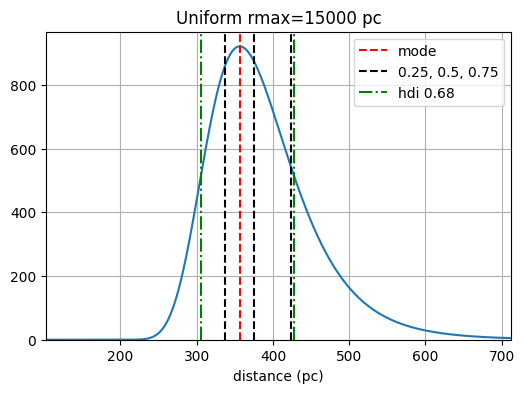

mode = 356 pc
25% = 338 pc
50% = 376 pc
75% = 424 pc
hdi = 306-428 pc
hdi = +71/-51 pc


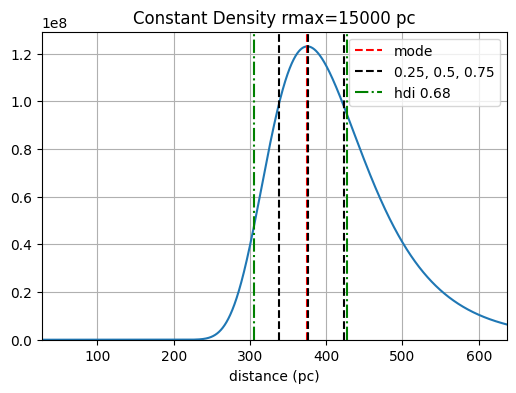

mode = 375 pc
25% = 338 pc
50% = 376 pc
75% = 424 pc
hdi = 306-428 pc
hdi = +52/-70 pc


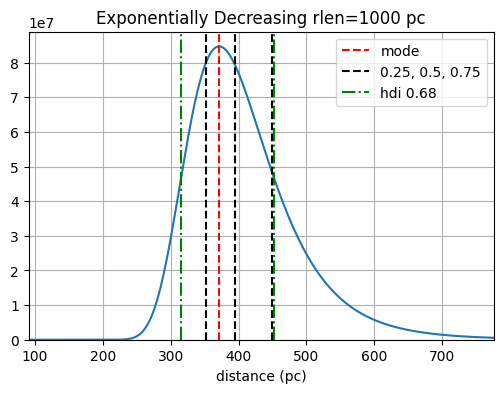

mode = 371 pc
25% = 352 pc
50% = 395 pc
75% = 449 pc
hdi = 315-452 pc
hdi = +81/-56 pc


In [161]:
### Uniform
mode = r[np.argmax(posterior_uniform)]
p1 = lambda x: posterior.uniform(x, rmax)
util = Util(p1, 0, rmax)
q50 = util.percentile(perc=0.5, min=1, max=rmax)
q25 = util.percentile(perc=0.25, min=1, max=rmax)
q75 = util.percentile(perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = util.hdi(perc=hdi_perc, res=1E5, min=1.0, max=rmax)
x_upperLim = 1000
x_lowerLim = 0
if((hdi_upper-mode)*5+mode < x_upperLim): x_upperLim = (hdi_upper-mode)*5 + mode
if(mode - (mode-hdi_below)*5 > x_lowerLim): x_lowerLim = mode - (mode-hdi_below)*5

plt.figure(figsize=(6,4))
plt.plot(r, p1(r))
plt.grid()
plt.xlim(x_lowerLim, x_upperLim)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Uniform rmax={int(rmax)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")
print(f"hdi = +{(hdi_upper-mode):.0f}/-{(mode-hdi_below):.0f} pc")

### Const Dens
mode = r[np.argmax(posterior_constant)]
p2 = lambda x: posterior.constant_density(x, rmax)
util = Util(p1, 0, rmax)
q50 = util.percentile(perc=0.5, min=1, max=rmax)
q25 = util.percentile(perc=0.25, min=1, max=rmax)
q75 = util.percentile(perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = util.hdi(perc=hdi_perc, res=1E5, min=1.0, max=rmax)
x_upperLim = rmax
x_lowerLim = 0
if((hdi_upper-mode)*5+mode < x_upperLim): x_upperLim = (hdi_upper-mode)*5 + mode
if(mode - (mode-hdi_below)*5 > x_lowerLim): x_lowerLim = mode - (mode-hdi_below)*5

plt.figure(figsize=(6,4))
plt.plot(r, p2(r))
plt.grid()
plt.xlim(x_lowerLim, x_upperLim)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Constant Density rmax={int(rmax)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")
print(f"hdi = +{(hdi_upper-mode):.0f}/-{(mode-hdi_below):.0f} pc")

### Exp Dec
mode = r[np.argmax(posterior_exponential)]
p3 = lambda x: posterior.exponentially_decreasing(x, L)
util = Util(p3, 0, rmax)
q50 = util.percentile(perc=0.5, min=1, max=rmax)
q25 = util.percentile(perc=0.25, min=1, max=rmax)
q75 = util.percentile(perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = util.hdi(perc=hdi_perc, res=1E5, min=1.0, max=rmax)
x_upperLim = rmax
x_lowerLim = 0
if((hdi_upper-mode)*5+mode < x_upperLim): x_upperLim = (hdi_upper-mode)*5 + mode
if(mode - (mode-hdi_below)*5 > x_lowerLim): x_lowerLim = mode - (mode-hdi_below)*5

plt.figure(figsize=(6,4))
plt.plot(r, p3(r))
plt.grid()
plt.xlim(x_lowerLim, x_upperLim)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Exponentially Decreasing rlen={int(L)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")
print(f"hdi = +{(hdi_upper-mode):.0f}/-{(mode-hdi_below):.0f} pc")